In [1]:
import cv2
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import numpy as np
from time import time

In [2]:
path = '/Users/alexbovyrin/temp'

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Аугментации для тренировочного датасета
train_transform = transforms.Compose([
    transforms.RandomRotation(10),           # поворот на ±10°
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  # случайный сдвиг
    transforms.ToTensor(),                   # преобразование в тензор
    transforms.Normalize((0.5,), (0.5,))     # нормализация
])

# Без аугментаций для теста
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [4]:
trainset = datasets.MNIST(path, download=True, train=True, transform=transform)
testset = datasets.MNIST(path, download=True, train=False, transform=transform)

In [5]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [6]:
dataiter = iter(trainloader)
while False:
    images, labels = dataiter.next()

    cv2.imshow('image', images[0].numpy().squeeze())
    if cv2.waitKey()==27:
        cv2.destroyAllWindows()
        break;

In [7]:
input_size = 28*28
hidden_sizes = [input_size, 64]
output_size = 10
net = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                    )

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.003, momentum=0.9)


In [9]:
images, labels = next(iter(trainloader))
res = net(images.view(-1, 28 * 28))
loss = criterion(res, labels)
print(loss)

tensor(2.2938, grad_fn=<NllLossBackward>)


In [10]:
time0 = time()
epochs = 1

for e in range(epochs):
    running_loss = 0
    for i, (images, labels) in enumerate(trainloader, 0):
        optimizer.zero_grad()
        res = net(images.view(-1, 28 * 28))
        loss = criterion(res, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        dbg_samples = 100
        if (i + 1) % dbg_samples == 0:    
            print('[%d, %5d] loss: %.3f' %
                  (e+1, i+1, running_loss / dbg_samples))
            running_loss = 0.0
        
print("\nTraining Time (in minutes) =",(time()-time0)/60)

[1,   100] loss: 1.883
[1,   200] loss: 0.781
[1,   300] loss: 0.507
[1,   400] loss: 0.422
[1,   500] loss: 0.392
[1,   600] loss: 0.380
[1,   700] loss: 0.358
[1,   800] loss: 0.333
[1,   900] loss: 0.320

Training Time (in minutes) = 0.26439294815063474


In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.view(images.shape[0], -1)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: %d %%' % (100 * correct / total))

Accuracy: 91 %


In [12]:
x = torch.randn(64, 1, 28*28)

In [13]:
torch.onnx.export(net, x, path+'/mlp.onnx')

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size= 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
class DepthwiseSeparableNet(nn.Module):
    def __init__(self):
        super(DepthwiseSeparableNet, self).__init__()
        
        self.dw_conv1 = nn.Conv2d(1, 1, kernel_size=5, padding=0, groups=1)
        self.pw_conv1 = nn.Conv2d(1, 8, kernel_size=1)

        self.pool = nn.MaxPool2d(2, 2)

        self.dw_conv2 = nn.Conv2d(8, 8, kernel_size=3, padding=0, groups=8)
        self.pw_conv2 = nn.Conv2d(8, 16, kernel_size=1)

        self.fc1 = nn.Linear(16 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.pw_conv1(self.dw_conv1(x))))
        x = self.pool(F.relu(self.pw_conv2(self.dw_conv2(x))))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
net = Net()
DSNet = DepthwiseSeparableNet()

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.003, momentum=0.9)

time0 = time()
epochs = 1

for e in range(epochs):
    running_loss = 0
    for i, (images, labels) in enumerate(trainloader, 0):
        optimizer.zero_grad()
        res = net(images)
        loss = criterion(res, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        dbg_samples = 100
        if (i + 1) % dbg_samples == 0:    
            print('[%d, %5d] loss: %.3f' %
                  (e+1, i+1, running_loss / dbg_samples))
            running_loss = 0.0
        
print("\nTraining Time (in minutes) =",(time()-time0)/60)

[1,   100] loss: 0.162
[1,   200] loss: 0.150
[1,   300] loss: 0.135
[1,   400] loss: 0.115
[1,   500] loss: 0.122
[1,   600] loss: 0.121
[1,   700] loss: 0.097
[1,   800] loss: 0.108
[1,   900] loss: 0.096

Training Time (in minutes) = 0.3424139142036438


In [19]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: %d %%' % (100 * correct / total))

Accuracy: 97 %


In [20]:
x = torch.randn(64, 1, 28,28)

In [21]:
torch.onnx.export(net, x, path+'/conv1.onnx')

In [22]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 8, 3, padding=1)
        self.fc1 = nn.Linear(8 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.25)
        

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x2 = F.relu(self.conv2(x))
        x = x + x2
        x = self.pool(x)
        x = x.view(-1, 8 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [23]:
net = Net()

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.003, momentum=0.9)

time0 = time()
epochs = 1

for e in range(epochs):
    running_loss = 0
    for i, (images, labels) in enumerate(trainloader, 0):
        optimizer.zero_grad()
        res = net(images)
        loss = criterion(res, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        dbg_samples = 100
        if (i + 1) % dbg_samples == 0:    
            print('[%d, %5d] loss: %.3f' %
                  (e+1, i+1, running_loss / dbg_samples))
            running_loss = 0.0
        
print("\nTraining Time (in minutes) =",(time()-time0)/60)


correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: %d %%' % (100 * correct / total))

[1,   100] loss: 2.283
[1,   200] loss: 2.114
[1,   300] loss: 1.071
[1,   400] loss: 0.480
[1,   500] loss: 0.318
[1,   600] loss: 0.258
[1,   700] loss: 0.216
[1,   800] loss: 0.192
[1,   900] loss: 0.191

Training Time (in minutes) = 0.3792750835418701
Accuracy: 95 %


In [25]:
torch.onnx.export(net, x, path+'/conv2.onnx')

In [26]:
model=cv2.dnn.readNetFromONNX(path+'/conv1.onnx')

In [27]:
img = cv2.imread(path+'/3.png',0)

In [28]:
from matplotlib import pyplot as plt

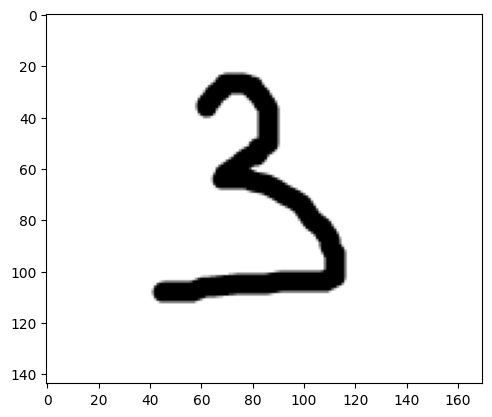

In [29]:
plt.imshow(img, cmap="gray")

In [30]:
img = 255-img
img = cv2.resize(img, (28, 28), interpolation = cv2.INTER_AREA)
blob = cv2.dnn.blobFromImage(img, 1./128, (28,28), (127.5,127.5,127.5), True)

In [31]:
model.setInput(blob)
outs = model.forward()
np.argmax(outs)

3

In [44]:
image = cv2.imread(path+'/0-9.png')

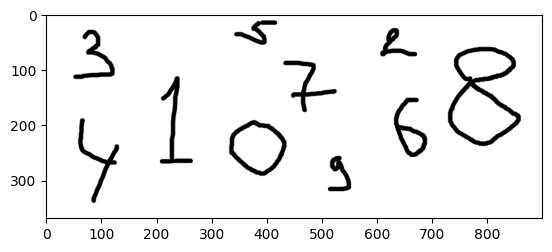

In [45]:
plt.imshow(image, cmap="gray")

In [46]:
img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, img = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
height, width = img.shape[:2]

In [47]:
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    cv2.rectangle(image, (x, y), (x+w-1, y+h-1), (255,255,0),1)
    sz2 = int(1.1*max(w,h)/2)
    xc = x + int(w/2)
    yc = y + int(h/2)
    cv2.rectangle(image, (xc-sz2, yc-sz2), (xc+sz2, yc+sz2), (255,0,0),1)
    img2 = img[max(0,yc-sz2):min(yc+sz2,height-1),max(0,xc-sz2):min(width-1,xc+sz2)]
    img2 = cv2.resize(img2, (28, 28))
    blob = cv2.dnn.blobFromImage(img2, 1./127, (28,28), (127,127,127), True)
    model.setInput(blob)
    outs = model.forward()
    res = np.argmax(outs)
    
    cv2.putText(image, str(res), (x-10, y+10),  cv2.FONT_HERSHEY_SIMPLEX,
	1.5, (50, 50, 255),1)

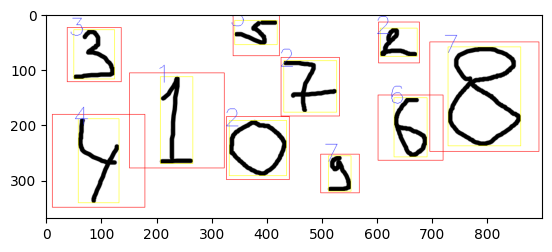

In [48]:
plt.imshow(image, cmap="gray")